# Constructing a Contrarian Trading Strategy

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime

### Importing and Cleaning Data

In [2]:
sentiment = pd.read_excel('Bull_Bear_Spread.xlsx')
sentiment.head()

,Date,Close
0,1987-07-24 00:00:00,0.22
1,1987-07-31 00:00:00,0.00
2,1987-08-07 00:00:00,0.27
3,1987-08-14 00:00:00,0.25
4,1987-08-21 00:00:00,0.60


In [3]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2044 non-null   object 
 1   Close   2042 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.2+ KB


In [4]:
sentiment.isnull().sum()

Date     11
Close    13
dtype: int64

In [5]:
sentiment.tail()

,Date,Close
2050,Count '18,52.0
2051,Count '19,52.0
2052,Count '20,53.0
2053,Count '21,51.0
2054,Count '22,52.0


In [ ]:
#further data exploration shows that the date column has a lot of data other than the dates and sentiment scores
#getting only those rows with dates in date col to build strategy

In [6]:
date_index = [i for i in sentiment.index if type(sentiment['Date'][i]) == datetime.datetime]

In [7]:
df = sentiment[sentiment.index.isin(date_index)]

In [8]:
df

,Date,Close
0,1987-07-24 00:00:00,0.220000
1,1987-07-31 00:00:00,0.000000
2,1987-08-07 00:00:00,0.270000
3,1987-08-14 00:00:00,0.250000
4,1987-08-21 00:00:00,0.600000
...,...,...
1851,2023-01-26 00:00:00,-0.083094
1852,2023-02-02 00:00:00,-0.046512
1853,2023-02-09 00:00:00,0.125000
1854,2023-02-16 00:00:00,0.052941


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856 entries, 0 to 1855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1856 non-null   object 
 1   Close   1855 non-null   float64
dtypes: float64(1), object(1)
memory usage: 43.5+ KB


In [10]:
#importing S&P data

sp500 = yf.download("^GSPC")
sp500 = sp500[['Adj Close']]
sp500

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1927-12-30 00:00:00-05:00,17.660000
1928-01-03 00:00:00-05:00,17.760000
1928-01-04 00:00:00-05:00,17.719999
1928-01-05 00:00:00-05:00,17.549999
1928-01-06 00:00:00-05:00,17.660000
...,...
2023-03-27 00:00:00-04:00,3977.530029
2023-03-28 00:00:00-04:00,3971.270020
2023-03-29 00:00:00-04:00,4027.810059


In [11]:
df = df.set_index(['Date'], drop = True)

### Creating the Strategy Dataframe

In [12]:
#merging the closing price of index with the sentiment data

strat_df = pd.merge_asof(df, sp500, left_index = True, right_index = True)
strat_df

,Close,Adj Close
Date,,
1987-07-24,0.220000,307.809998
1987-07-31,0.000000,318.049988
1987-08-07,0.270000,322.089996
1987-08-14,0.250000,334.649994
1987-08-21,0.600000,334.839996
...,...,...
2023-01-26,-0.083094,4016.219971
2023-02-02,-0.046512,4119.209961
2023-02-09,0.125000,4117.859863


In [13]:
strat_df.columns = (['Sentiment', 'Adj Close'])

In [15]:
#defining the returns as the percentage change in closing price between one week and the next

strat_df["returns"] = np.log(strat_df["Adj Close"]).diff()

In [16]:
strat_df

,Sentiment,Adj Close,returns
Date,,,
1987-07-24,0.220000,307.809998,NaN
1987-07-31,0.000000,318.049988,0.032726
1987-08-07,0.270000,322.089996,0.012622
1987-08-14,0.250000,334.649994,0.038254
1987-08-21,0.600000,334.839996,0.000568
...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992
2023-02-02,-0.046512,4119.209961,0.025320
2023-02-09,0.125000,4117.859863,-0.000328


### Building the Strategy

We have picked z-score as the threshold metric for measuring change in investor sentiment. Z-scores based on the previous year's average sentiment score have been used to identify unusually high or low sentiment (anomalies). An anomaly has been defined as any sentiment with a z-score greater than 2 standard deviations in the upward or downward direction, following the rule of thumb for identifying outliers. The exact defining of signals has been described ahead.

#### Creating z-score based on previous year's mean and standard deviation for signal generation

In [14]:
grouped_data = strat_df.groupby(strat_df.index.year)

In [17]:
strat_df['Yearly_Mean'] = grouped_data['Sentiment'].transform(lambda x: x.mean())
strat_df['Yearly_Std'] = grouped_data['Sentiment'].transform(lambda x: x.std())
strat_df['Prev_Year_Mean'] = strat_df['Yearly_Mean'].shift(52)
strat_df['Prev_Year_Std'] = strat_df['Yearly_Std'].shift(52)

In [45]:
#z-score creation
strat_df['Sentiment_Zscore'] = (strat_df['Sentiment'] - strat_df['Prev_Year_Mean'])/strat_df['Prev_Year_Std']
strat_df

,Sentiment,Adj Close,returns,Yearly_Mean,Yearly_Std,Prev_Year_Mean,Prev_Year_Std,Sentiment_Zscore
Date,,,,,,,,
1987-07-24,0.220000,307.809998,NaN,0.147917,0.174380,NaN,NaN,NaN
1987-07-31,0.000000,318.049988,0.032726,0.147917,0.174380,NaN,NaN,NaN
1987-08-07,0.270000,322.089996,0.012622,0.147917,0.174380,NaN,NaN,NaN
1987-08-14,0.250000,334.649994,0.038254,0.147917,0.174380,NaN,NaN,NaN
1987-08-21,0.600000,334.839996,0.000568,0.147917,0.174380,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,-0.064479,0.116359,-0.214647,0.11926,1.103073
2023-02-02,-0.046512,4119.209961,0.025320,-0.064479,0.116359,-0.214647,0.11926,1.409814
2023-02-09,0.125000,4117.859863,-0.000328,-0.064479,0.116359,-0.214647,0.11926,2.847947


#### Creating the signals

Contrarian strategy definition:
- When z-score > 2 => very bullish sentiment => go short
- When z-score < -2 => very bearish sentiment => go long

In [50]:
strat_df.dropna(inplace=True)        #since using prev year sentiment, cant build strategy on first year data
strat_df

,Sentiment,Adj Close,returns,Yearly_Mean,Yearly_Std,Prev_Year_Mean,Prev_Year_Std,Sentiment_Zscore
Date,,,,,,,,
1988-07-22,-0.100000,266.660004,-0.013410,0.022115,0.137161,0.147917,0.17438,-1.421701
1988-07-29,0.000000,266.019989,-0.002403,0.022115,0.137161,0.147917,0.17438,-0.848241
1988-08-05,-0.090000,271.929993,0.021973,0.022115,0.137161,0.147917,0.17438,-1.364355
1988-08-12,0.000000,262.750000,-0.034342,0.022115,0.137161,0.147917,0.17438,-0.848241
1988-08-19,-0.090000,261.029999,-0.006568,0.022115,0.137161,0.147917,0.17438,-1.364355
...,...,...,...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,-0.064479,0.116359,-0.214647,0.11926,1.103073
2023-02-02,-0.046512,4119.209961,0.025320,-0.064479,0.116359,-0.214647,0.11926,1.409814
2023-02-09,0.125000,4117.859863,-0.000328,-0.064479,0.116359,-0.214647,0.11926,2.847947


In [65]:
strat_df["Signal"] = 0
    
for j in strat_df.index:
    if strat_df.loc[j, "Sentiment_Zscore"] > 2:
        strat_df.loc[j, "Signal"] = -1
    elif strat_df.loc[j, "Sentiment_Zscore"] < -2:
        strat_df.loc[j, "Signal"] = 1

### Testing the Strategy - Strategy Metrics

We are constructing this strategy in-sample without splitting the data into training and testing sets for simplicity.

In [68]:
#calculating the returns
strat_df["cumulative_returns"] = np.exp((strat_df["Signal"].shift()*strat_df.returns).cumsum())-1
strat_df["strat_returns"] = strat_df["Signal"].shift()*strat_df.returns

In [69]:
strat_df

,Sentiment,Adj Close,returns,Yearly_Mean,Yearly_Std,Prev_Year_Mean,Prev_Year_Std,Sentiment_Zscore,Signal,cumulative_returns,strat_returns
Date,,,,,,,,,,,
1988-07-22,-0.100000,266.660004,-0.013410,0.022115,0.137161,0.147917,0.17438,-1.421701,0,NaN,NaN
1988-07-29,0.000000,266.019989,-0.002403,0.022115,0.137161,0.147917,0.17438,-0.848241,0,0.000000,-0.000000
1988-08-05,-0.090000,271.929993,0.021973,0.022115,0.137161,0.147917,0.17438,-1.364355,0,0.000000,0.000000
1988-08-12,0.000000,262.750000,-0.034342,0.022115,0.137161,0.147917,0.17438,-0.848241,0,0.000000,-0.000000
1988-08-19,-0.090000,261.029999,-0.006568,0.022115,0.137161,0.147917,0.17438,-1.364355,0,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,-0.064479,0.116359,-0.214647,0.11926,1.103073,0,0.305617,0.000000
2023-02-02,-0.046512,4119.209961,0.025320,-0.064479,0.116359,-0.214647,0.11926,1.409814,0,0.305617,0.000000
2023-02-09,0.125000,4117.859863,-0.000328,-0.064479,0.116359,-0.214647,0.11926,2.847947,-1,0.305617,-0.000000


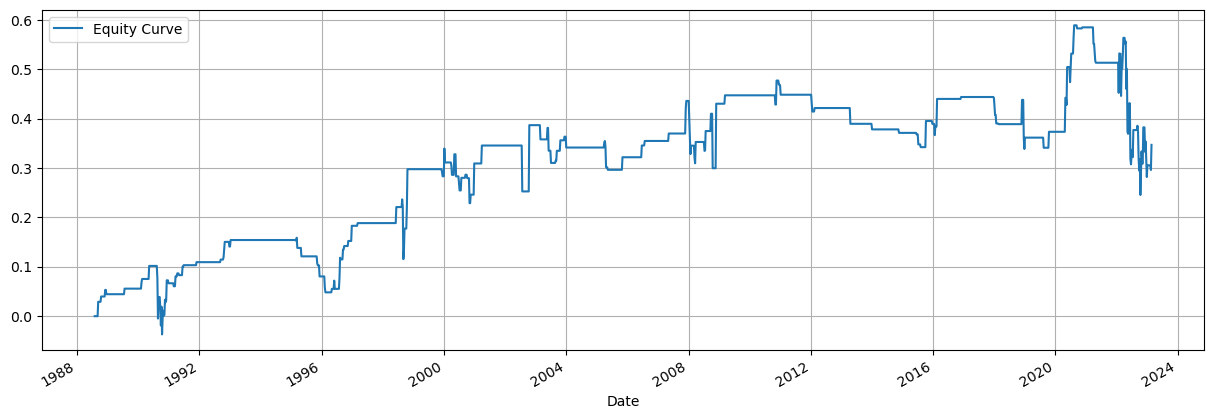

In [70]:
#equity curve
plt.figure(figsize = (15, 5))
(strat_df["cumulative_returns"]).plot()

#plt.title("Price Earnings Strategy:"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))
plt.legend(["Equity Curve"])
plt.grid()

We can see that over time this strategy makes money and is profitable!

#### Total Rate of Return

In [71]:
ror = strat_df['cumulative_returns'][-1]*100
print("Total Rate of Return is %.2f%%" %ror)

Total Rate of Return is 34.71%


#### Annualized Return

In [72]:
t = len(strat_df)/52
P = 1000
A = (1+0.347101)*P
annual = ((A/P)**(1/t)-1)*100

print("Annualized Rate of Return is %.2f%%" %annual)

Annualized Rate of Return is 0.86%


#### Rate of return only over the days we hold a position

In [74]:
len(strat_df[strat_df["Signal"] != 0])

202

Positions are held only 202 times => there are only 202 anomalies or "large" movements in investor sentiment over this 35 year period.

In [75]:
strat_df[strat_df["Signal"] != 0]['cumulative_returns'][-1]

0.2962554724301689

In [77]:
P = 1000
A = (1+0.296255)*P
T = len(strat_df[strat_df["Signal"] != 0])/52     #since it is weekly


((A/P)**(1/T)-1)*100

6.907807104613384

We earn an annualized rate of return of 6.9% for the 202 weeks a position was held in the market.

#### Sharpe Ratio

In [80]:
#importing the risk free rates file
risk_free = pd.read_csv('1-year-treasury-rate-yield-chart.csv', index_col = 0, parse_dates = True)

In [84]:
cols = [i for i in strat_df.columns]
cols.append('annual_rfr')

In [85]:
sharpe_trial = pd.merge_asof(strat_df, risk_free,left_index = True, right_index = True)

sharpe_trial.columns = cols
sharpe_trial

,Sentiment,Adj Close,returns,Yearly_Mean,Yearly_Std,Prev_Year_Mean,Prev_Year_Std,Sentiment_Zscore,Signal,cumulative_returns,strat_returns,annual_rfr
Date,,,,,,,,,,,,
1988-07-22,-0.100000,266.660004,-0.013410,0.022115,0.137161,0.147917,0.17438,-1.421701,0,NaN,NaN,7.78
1988-07-29,0.000000,266.019989,-0.002403,0.022115,0.137161,0.147917,0.17438,-0.848241,0,0.000000,-0.000000,7.90
1988-08-05,-0.090000,271.929993,0.021973,0.022115,0.137161,0.147917,0.17438,-1.364355,0,0.000000,0.000000,8.03
1988-08-12,0.000000,262.750000,-0.034342,0.022115,0.137161,0.147917,0.17438,-0.848241,0,0.000000,-0.000000,8.23
1988-08-19,-0.090000,261.029999,-0.006568,0.022115,0.137161,0.147917,0.17438,-1.364355,0,0.000000,-0.000000,8.27
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,-0.064479,0.116359,-0.214647,0.11926,1.103073,0,0.305617,0.000000,NaN
2023-02-02,-0.046512,4119.209961,0.025320,-0.064479,0.116359,-0.214647,0.11926,1.409814,0,0.305617,0.000000,NaN
2023-02-09,0.125000,4117.859863,-0.000328,-0.064479,0.116359,-0.214647,0.11926,2.847947,-1,0.305617,-0.000000,NaN


In [86]:
return_frame = sharpe_trial[["strat_returns"]].copy().dropna()

In [88]:
return_frame["rf"] = (sharpe_trial[["annual_rfr"]].dropna()/100+1)**(1/52)-1

In [89]:
return_frame

,strat_returns,rf
Date,,
1988-07-29,-0.000000,0.001463
1988-08-05,0.000000,0.001486
1988-08-12,-0.000000,0.001522
1988-08-19,-0.000000,0.001529
1988-08-26,-0.000000,0.001538
...,...,...
2023-01-26,0.000000,NaN
2023-02-02,0.000000,NaN
2023-02-09,-0.000000,NaN


In [91]:
excess_return = return_frame["strat_returns"]- return_frame["rf"]

n = len(excess_return)
mean = excess_return.mean()
std = np.sqrt(np.sum(np.square(excess_return))/(n-1))
sharpe = mean/std

print("The Sharpe Ratio is:", sharpe)

The Sharpe Ratio is: -0.04467419163281641


Since the Sharpe ratio is so low, it is not a good sign as the strategy does not have high returns when compared to the investment risk taken over the risk-free rate! The negative value implies that an investor would be better off investing in risk-free treasury bonds instead.  
This is interesting to note as this is not the conclusion one would draw from the equity curve at first glance. It is important to look at returns considering the amount of risk taken to build a good trading strategy by taking opportunity costs into account.

#### Gini Coefficient

In [92]:
def GINI_COEF(returns):
    # get the number of periods -> will allow us to calculate the areas
    periods = len(returns)
    
    # sort values and sum to calculate the lorenz curve
    LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
    # start from 0
    LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)
    Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
    Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])
    
    # calculate the area of A+B
    UpArea = 0
    for i in range(1,len(returns)):
        UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods)/2)
    gini = UpArea / AllArea
    return(gini[0])

In [94]:
returns = strat_df[['strat_returns']][1:]
returns.columns = ['Returns']

In [96]:
GINI_COEF(returns)

C:\Users\agarw\AppData\Local\Temp\ipykernel_31284\2616558606.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)


0.9692915361317196

In [98]:
periods = len(returns)
    
# sort values and sum to calculate the lorenz curve
LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
# start from 0
LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)
Line = LorenzCurve.copy()
# Form the line that encompasses A and B
Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])

C:\Users\agarw\AppData\Local\Temp\ipykernel_31284\1133589100.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LorenzCurve = pd.DataFrame({ 'Returns': [0]}).append(LorenzCurve)


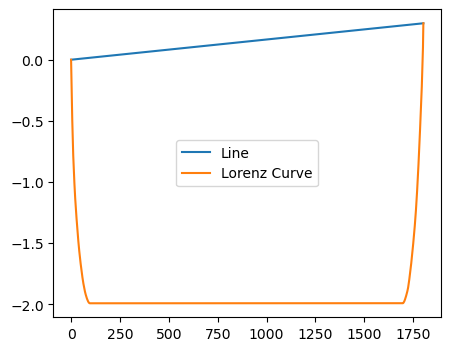

In [102]:
plt.figure(figsize = (5, 4))
plt.plot(Line["Returns"].values)
plt.plot(LorenzCurve["Returns"].values)
plt.legend(["Line", "Lorenz Curve"])

Large Gini implies the returns are not equally spread out over the time period. Also visible in the large distance between the Lorenz Curve and the equality line. Whether this is a good feature in a strategy or not is very subjective and depends on what kind of investor looks at it.